# Manifold GP Semi-Supervised Learning via Precision Matrix on 1D Manifold

## Preamble

This notebook provides an example of how to perform Gaussian Process Regression on a 1D manifold. In this example we consider a supervised learning scenario, namely the number of labeled data points is equivalent to the number of the sampled points from the underlying manifold.

In [1]:
import torch
import gpytorch
import numpy as np
import yaml

%matplotlib widget
import matplotlib.pyplot as plt
from importlib.resources import files

from manifold_gp.kernels.riemann_matern_kernel import RiemannMaternKernel
from manifold_gp.models.riemann_gp import RiemannGP
from manifold_gp.models.vanilla_gp import VanillaGP
from manifold_gp.utils.mesh_helper import groundtruth_from_samples
from manifold_gp.utils.file_read import get_data
from manifold_gp.utils.plotting import colormap_diverging, colormap_left, colormap_right, colorbar, beautify

from manifold_gp.priors.inverse_gamma_prior import InverseGammaPrior
from gpytorch.priors import NormalPrior, GammaPrior

In [2]:
with open("configs/semi_supervised_learning.yaml", "r") as yamlfile:
    config = yaml.load(yamlfile, Loader=yaml.SafeLoader)["1d_example"]

## Dataset Preprocessing

### Load

In [3]:
data_path = files('manifold_gp.data').joinpath('dumbbell.msh')
data = get_data(data_path, "Nodes", "Elements")

vertices = data['Nodes'][:, 1:-1]
edges = data['Elements'][:, -2:].astype(int) - 1
truth, geodesics = groundtruth_from_samples(vertices,edges)

sampled_x = torch.from_numpy(vertices).float()
sampled_y = torch.from_numpy(truth).float()
(m, n) = sampled_x.shape

num_train = config["data"]["num_train"] # 10
num_test = config["data"]["num_test"] # 1000
normalize_features = config["data"]["normalize_features"] # False
normalize_labels = config["data"]["normalize_labels"] # True

### Noise Features

In [4]:
noise_sampled_x = config["noise"]["features"]
noisy_x = sampled_x + noise_sampled_x * torch.randn(m, n)

### Trainset & Testset

In [5]:
torch.manual_seed(1337)
rand_idx = torch.randperm(m)
train_idx = rand_idx[:num_train]
train_x, train_y = noisy_x[train_idx, :], sampled_y[train_idx]

noise_train_y = config["noise"]["labels_train"] # 0.01
train_y += noise_train_y * torch.randn(num_train)

test_idx = rand_idx[num_train:num_train+num_test]
test_x, test_y = sampled_x[test_idx, :], sampled_y[test_idx]

noise_test_y = config["noise"]["labels_test"] # 0.0
test_y += noise_test_y * torch.randn(num_test)

if normalize_features:
    mu_x, std_x = noisy_x.mean(dim=-2, keepdim=True), train_x.std(dim=-2, keepdim=True) + 1e-6
    noisy_x.sub_(mu_x).div_(std_x)
    train_x.sub_(mu_x).div_(std_x)
    test_x.sub_(mu_x).div_(std_x)
    
if normalize_labels:
    mu_y, std_y = train_y.mean(), train_y.std()
    train_y.sub_(mu_y).div_(std_y)
    test_y.sub_(mu_y).div_(std_y)
    sampled_y.sub_(mu_y).div_(std_y)

### Move Data to Device

In [6]:
noisy_x, sampled_y = noisy_x.contiguous(), sampled_y.contiguous()
train_x, train_y = train_x.contiguous(), train_y.contiguous()
test_x, test_y = test_x.contiguous(), test_y.contiguous()

use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
noisy_x = noisy_x.to(device)
train_x, train_y = train_x.to(device), train_y.to(device)
test_x, test_y = test_x.to(device), test_y.to(device)

if normalize_features:
    mu_x, std_x = mu_x.to(device), std_x.to(device)

## Vanilla Model

In [7]:
%%capture
likelihood_vanilla = gpytorch.likelihoods.GaussianLikelihood()

if config["vanilla_model"]["kernel"] == 'rbf':
    kernel_vanilla = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
elif config["vanilla_model"]["kernel"] == 'rff':
    kernel_vanilla = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RFFKernel(100))
else:
    kernel_vanilla = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu=2.5))

model_vanilla = VanillaGP(
    train_x, 
    train_y, 
    likelihood_vanilla, 
    kernel_vanilla
).to(device)

### Train

In [8]:
if config["vanilla_model"]["train"]["optimize"]:
    model_vanilla.vanilla_train(lr=config["vanilla_model"]["train"]["learning_rate"], 
                                iter=config["vanilla_model"]["train"]["iterations"], 
                                verbose=config["vanilla_model"]["train"]["verbose"])

### Save

In [9]:
if config["vanilla_model"]["save"]:
        torch.save(model.state_dict(), '../models/1d_vanilla.pth')

### Load

In [10]:
if config["vanilla_model"]["load"]:
    model.load_state_dict(torch.load('../models/1d_vanilla.pth'))

## Manifold Model

In [11]:
%%capture
likelihood = gpytorch.likelihoods.GaussianLikelihood(
    noise_constraint=gpytorch.constraints.GreaterThan(1e-8),
    noise_prior=None  # NormalPrior(torch.tensor([0.0]).to(device),  torch.tensor([1/9]).sqrt().to(device))
)

kernel = gpytorch.kernels.ScaleKernel(
    RiemannMaternKernel(
        nu=config["manifold_model"]["nu"],
        nodes=noisy_x,
        neighbors=config["manifold_model"]["neighbors"],
        operator=config["manifold_model"]["operator"],
        method=config["manifold_model"]["method"],
        modes=config["manifold_model"]["modes"],
        bump_scale=config["manifold_model"]["bump_scale"],
        bump_decay=config["manifold_model"]["bump_decay"],
        prior_bandwidth=config["manifold_model"]["prior_bandwidth"],
    ),
    outputscale_prior=None  # NormalPrior(torch.tensor([1.0]).to(device), torch.tensor([1/9]).sqrt().to(device))
)

model = RiemannGP(train_x, train_y, likelihood, kernel, train_idx).to(device)

### Train

In [12]:
%%capture
hypers = {
    'likelihood.noise_covar.noise': 1e-2,
    'covar_module.base_kernel.epsilon': 0.5, # kernel.base_kernel.epsilon_prior.sample(), 0.5
    'covar_module.base_kernel.lengthscale': 1.0,
    'covar_module.outputscale': 1.0,
}
model.initialize(**hypers)

In [13]:
if config["vanilla_model"]["train"]["optimize"]:
    model.manifold_informed_train(lr=config["manifold_model"]["train"]["learning_rate"], 
                                  iter=config["manifold_model"]["train"]["iterations"], 
                                  verbose=config["manifold_model"]["train"]["verbose"])

/home/bernardo/.local/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Iter: 0, Loss: 13.688, NoiseVar: 0.010, SignalVar: 0.48597, Lengthscale: 1.000, Epsilon: 0.500
Iter: 1, Loss: 13.683, NoiseVar: 0.009, SignalVar: 0.44866, Lengthscale: 0.938, Epsilon: 0.462
Iter: 2, Loss: 13.673, NoiseVar: 0.009, SignalVar: 0.45134, Lengthscale: 0.957, Epsilon: 0.457
Iter: 3, Loss: 13.648, NoiseVar: 0.010, SignalVar: 0.46567, Lengthscale: 0.992, Epsilon: 0.465
Iter: 4, Loss: 13.652, NoiseVar: 0.010, SignalVar: 0.47924, Lengthscale: 1.029, Epsilon: 0.469
Iter: 5, Loss: 13.653, NoiseVar: 0.010, SignalVar: 0.48441, Lengthscale: 1.057, Epsilon: 0.464
Iter: 6, Loss: 13.639, NoiseVar: 0.010, SignalVar: 0.48139, Lengthscale: 1.075, Epsilon: 0.451
Iter: 7, Loss: 13.624, NoiseVar: 0.010, SignalVar: 0.47426, Lengthscale: 1.088, Epsilon: 0.434
Iter: 8, Loss: 13.620, NoiseVar: 0.010, SignalVar: 0.46773, Lengthscale: 1.105, Epsilon: 0.418
Iter: 9, Loss: 13.617, NoiseVar: 0.010, SignalVar: 0.46597, Lengthscale: 1.131, Epsilon: 0.405
Iter: 10, Loss: 13.605, NoiseVar: 0.010, SignalVar

In [14]:
print("NoiseVar: ", likelihood.noise.item(), "SignalVar: ", kernel.outputscale.item(), 
      "Lengthscale: ", kernel.base_kernel.lengthscale.item(), "Epsilon", kernel.base_kernel.epsilon.item())

NoiseVar:  4.133710899623111e-05 SignalVar:  0.6708597540855408 Lengthscale:  5.995224952697754 Epsilon 0.0493818037211895


### Extract eigenpairs

In [15]:
kernel.base_kernel.generate_eigenpairs()

exact


### Train with fixed graph bandwidth

In [16]:
if config["manifold_model"]["retrain"]["optimize"]:
    model.vanilla_train(lr=1e-1, iter=200, verbose=True)

In [17]:
print("NoiseVar: ", likelihood.noise.item(), "SignalVar: ", kernel.outputscale.item(), 
      "Lengthscale: ", kernel.base_kernel.lengthscale.item(), "Epsilon", kernel.base_kernel.epsilon.item())

NoiseVar:  4.133710899623111e-05 SignalVar:  0.6708597540855408 Lengthscale:  5.995224952697754 Epsilon 0.0493818037211895


### Save

In [18]:
if config["manifold_model"]["save"]:
        torch.save(model.state_dict(), '../models/1d_manifold.pth')

### Load

In [19]:
if config["manifold_model"]["load"]:
    model.load_state_dict(torch.load('../models/1d_manifold.pth'))

## Evaluation

In [20]:
%%capture
likelihood_vanilla.eval()
model_vanilla.eval()

likelihood.eval()
model.eval()
model.vanilla_model = model_vanilla

with torch.no_grad(), gpytorch.settings.fast_pred_var():
    model.posterior(test_x, noise=False)
    bump_scale = 1-kernel.base_kernel.bump_function(test_x)

### Vanilla

In [21]:
with gpytorch.settings.fast_pred_var(), gpytorch.settings.cg_tolerance(10000):
    error = test_y - model.mean("vanilla")
    covar = model.posterior_vanilla.lazy_covariance_matrix.evaluate_kernel()
    inv_quad, logdet = covar.inv_quad_logdet(inv_quad_rhs=error.unsqueeze(-1), logdet=True)
    rmse = (error.square().mean()).sqrt()
    nll = 0.5 * sum([inv_quad, logdet, error.size(-1)* np.log(2 * np.pi)])/error.size(-1)
print("RMSE: ", rmse)
print("NLL: ", nll)

RMSE:  tensor(0.9807, device='cuda:0')
NLL:  tensor(-2.1880, device='cuda:0')


### Manifold

In [22]:
with gpytorch.settings.fast_pred_var(), gpytorch.settings.cg_tolerance(10000):
    error = test_y - model.mean("manifold")
    covar = model.posterior_manifold.lazy_covariance_matrix.evaluate_kernel()
    inv_quad, logdet = covar.inv_quad_logdet(inv_quad_rhs=error.unsqueeze(-1), logdet=True)
    rmse = (error.square().mean()).sqrt()
    nll = 0.5 * sum([inv_quad, logdet, error.size(-1)* np.log(2 * np.pi)])/error.size(-1)
print("RMSE: ", rmse)
print("NLL: ", nll)

RMSE:  tensor(0.3938, device='cuda:0')
NLL:  tensor(-4.3955, device='cuda:0')


### Hybrid

In [23]:
with gpytorch.settings.fast_pred_var(), gpytorch.settings.cg_tolerance(10000):
    error = test_y - model.mean("hybrid")
    covar = model.posterior_manifold.lazy_covariance_matrix.evaluate_kernel() 
    + torch.outer(bump_scale,bump_scale) * model.posterior_vanilla.lazy_covariance_matrix.evaluate_kernel()
    inv_quad, logdet = covar.inv_quad_logdet(inv_quad_rhs=error.unsqueeze(-1), logdet=True)
    rmse = (error.square().mean()).sqrt()
    nll = 0.5 * sum([inv_quad, logdet, error.size(-1)* np.log(2 * np.pi)])/error.size(-1)
print("RMSE: ", rmse)
print("NLL: ", nll)

RMSE:  tensor(0.3938, device='cuda:0')
NLL:  tensor(-4.4572, device='cuda:0')


## Plot

In [24]:
# for better visualization
kernel.base_kernel.bump_decay = 1.
kernel.base_kernel.bump_scale = 10.0

with torch.no_grad(), gpytorch.settings.fast_pred_var(), gpytorch.settings.cg_tolerance(10000):
    preds_manifold = model(noisy_x)
    
    resolution = 100
    x, y = torch.meshgrid(torch.linspace(-2., 2., resolution), torch.linspace(-1., 1., resolution), indexing='xy')
    grid_x = torch.stack((torch.ravel(x), torch.ravel(y)), dim=1).to(device).requires_grad_(True)
    
    if normalize_features:
        model.posterior(grid_x.sub(mu_x).div(std_x))
        scale_ambient = kernel.base_kernel.bump_function(grid_x.sub(mu_x).div(std_x))
        sampled_x.mul_(std_x).add_(mu_x)
        train_x.mul_(std_x).add_(mu_x)
        test_x.mul_(std_x).add_(mu_x)
    else:
        model.posterior(grid_x)
        scale_ambient = kernel.base_kernel.bump_function(grid_x)

### Colormaps for posterior mean and standard deviation

In [25]:
vmin, vmax = -1.85, 1.85
cmap_mean = colormap_diverging(colormap='Spectral_r', vmin=vmin, vmax=vmax, center_color=np.array([1., 1., 1., 0.]), res=1000, step=0.1)
cmap_std = colormap_right(colormap='afmhot', right_color=np.array([1., 1., 1., 0.]), res=1000, step=0.1)

### Alpha Function

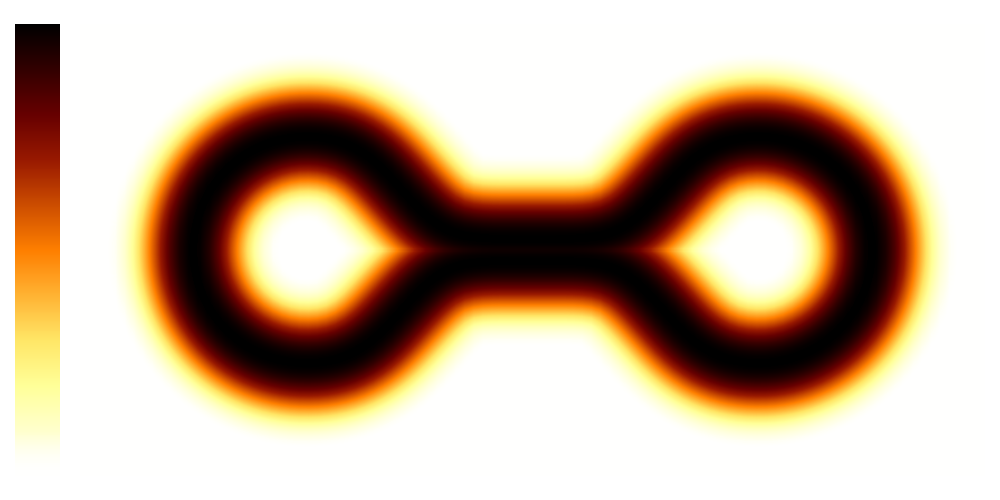

In [26]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
cmap_alpha = colormap_left(colormap='afmhot_r', left_color=np.array([1., 1., 1., 0.]), res=1000, step=0.1)
im = ax.contourf(x.cpu(), y.cpu(), scale_ambient.cpu().numpy().reshape(resolution, -1), 500, cmap=cmap_alpha)
for edge in edges:
    start = vertices[edge[0]]
    end = vertices[edge[1]]
    ax.plot([start[0], end[0]], [start[1], end[1]], color='black', zorder=1, linewidth='5',alpha=0.1)
colorbar(im, fig, ax)
beautify(fig, ax)
for c in im.collections:
    c.set_edgecolor("face")
    
if config["plot"]["save"]:
    fig.savefig("../media/1d_bump_function.png", format="png", dpi=100, bbox_inches="tight")

### Features Manifold

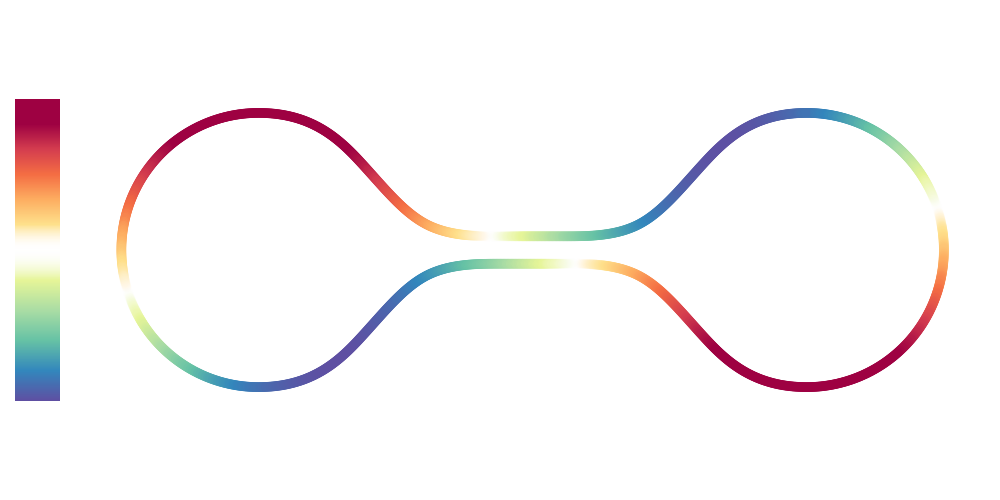

In [27]:
with torch.no_grad():
    e_features = kernel.base_kernel.eigenvectors[:,3].cpu().numpy()

cmap_feature = colormap_diverging(colormap='Spectral_r', 
                                  vmin=e_features.min(), vmax=e_features.max(), 
                                  center_color=np.array([1., 1., 1., 0.]), res=1000, step=0.1)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
im = ax.scatter(noisy_x.cpu().numpy()[:, 0], noisy_x.cpu().numpy()[:, 1], c=e_features, cmap=cmap_feature)
# circle = plt.Circle((noisy_x.cpu().numpy()[0, 0], noisy_x.cpu().numpy()[0, 1]), 3.0*kernel.base_kernel.epsilon.cpu().numpy(), color='k', fill=False)
# ax.add_patch(circle)
colorbar(im, fig, ax)
beautify(fig, ax)

if config["plot"]["save"]:
    fig.savefig("../media/1d_feature_manifold.png", format="png", dpi= 100, bbox_inches="tight")

### Features Ambient

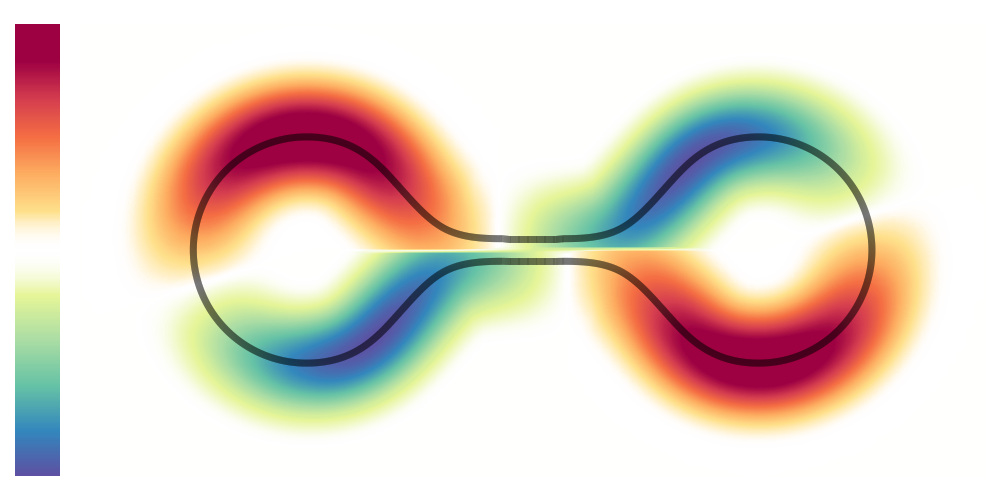

In [28]:
with torch.no_grad():
    laplace_features_ambient = kernel.base_kernel.features(grid_x, c=kernel.base_kernel.bump_scale)[:,3].cpu().numpy().reshape(resolution, -1)

cmap_feature = colormap_diverging(colormap='Spectral_r', 
                                  vmin=laplace_features_ambient.min(), vmax=laplace_features_ambient.max(), 
                                  center_color=np.array([1., 1., 1., 0.]), res=1000, step=0.1)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
im = ax.contourf(x.cpu(), y.cpu(), laplace_features_ambient, 500, cmap=cmap_feature)
for edge in edges:
    start = vertices[edge[0]]
    end = vertices[edge[1]]
    ax.plot([start[0], end[0]], [start[1], end[1]], color='black', zorder=1, linewidth='5',alpha=0.1)
colorbar(im, fig, ax)
beautify(fig, ax)
for c in im.collections:
    c.set_edgecolor("face")
    
if config["plot"]["save"]:    
    fig.savefig("../media/1d_feature_ambient.png", format="png", dpi=100, bbox_inches="tight")

### Kernel Manifold

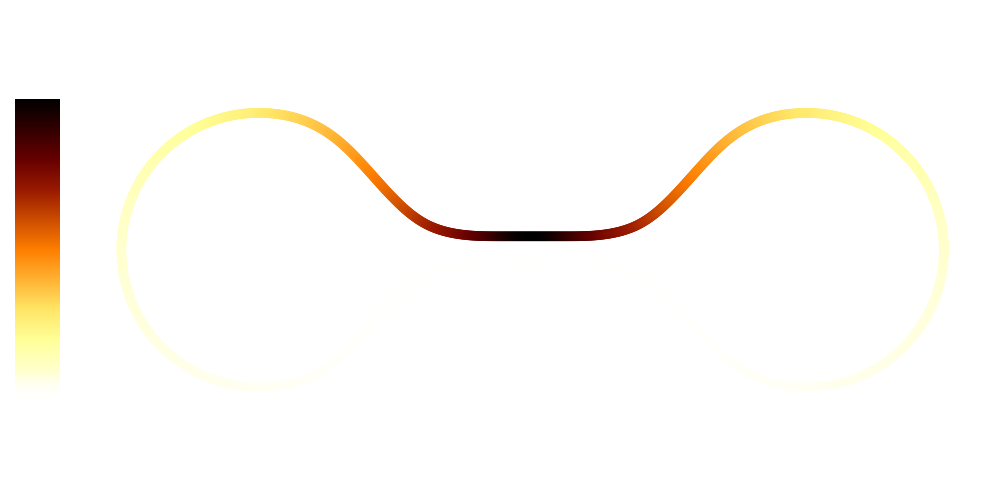

In [29]:
with torch.no_grad():
    kernel_center = 864
    k_base = kernel.base_kernel(noisy_x[kernel_center, :].unsqueeze(0), noisy_x[kernel_center, :].unsqueeze(0)).evaluate()
    kernel_manifold = (kernel.base_kernel(noisy_x[kernel_center, :].unsqueeze(0), noisy_x).evaluate()/k_base).squeeze().cpu().numpy()

cmap_kernel = colormap_left(colormap='afmhot_r', left_color=np.array([1., 1., 1., 0.]), res=1000, step=0.1)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
im = ax.scatter(noisy_x.cpu().numpy()[:, 0], noisy_x.cpu().numpy()[:, 1], c=kernel_manifold, cmap=cmap_kernel)
colorbar(im, fig, ax)
beautify(fig, ax)

if config["plot"]["save"]:
    fig.savefig("../media/1d_kernel_manifold.png", format="png", dpi=100, bbox_inches="tight")

### Kernel Ambient Space

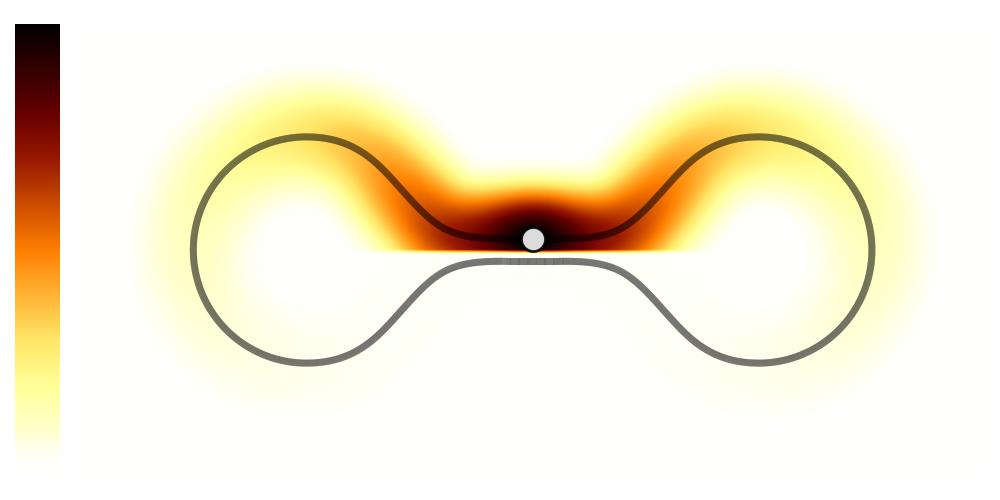

In [30]:
with torch.no_grad():
    kernel_center = 864
    k_base = kernel.base_kernel(noisy_x[kernel_center, :].unsqueeze(0), noisy_x[kernel_center, :].unsqueeze(0)).evaluate()
    kernel_ambient = (kernel.base_kernel(noisy_x[kernel_center, :].unsqueeze(0), grid_x).evaluate()/k_base).squeeze().cpu().numpy().reshape(resolution, -1)

cmap_kernel = colormap_left(colormap='afmhot_r', left_color=np.array([1., 1., 1., 0.]), res=1000, step=0.1)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
im = ax.contourf(x.cpu(), y.cpu(), kernel_ambient, 500, cmap=cmap_kernel)
ax.scatter(noisy_x.cpu().numpy()[kernel_center, 0], noisy_x.cpu().numpy()[kernel_center, 1], facecolors='whitesmoke', s=300.0, zorder=2, 
       edgecolors='black', linewidth=2, alpha=0.9)
for edge in edges:
    start = vertices[edge[0]]
    end = vertices[edge[1]]
    ax.plot([start[0], end[0]], [start[1], end[1]], color='black', zorder=1, linewidth='5',alpha=0.1)
colorbar(im, fig, ax, ticks=[vmin, 0, vmax])
beautify(fig, ax)
for c in im.collections:
    c.set_edgecolor("face")

if config["plot"]["save"]:
    fig.savefig("../media/1d_kernel_ambient.png", format="png", dpi=100, bbox_inches="tight")

### Ground Truth

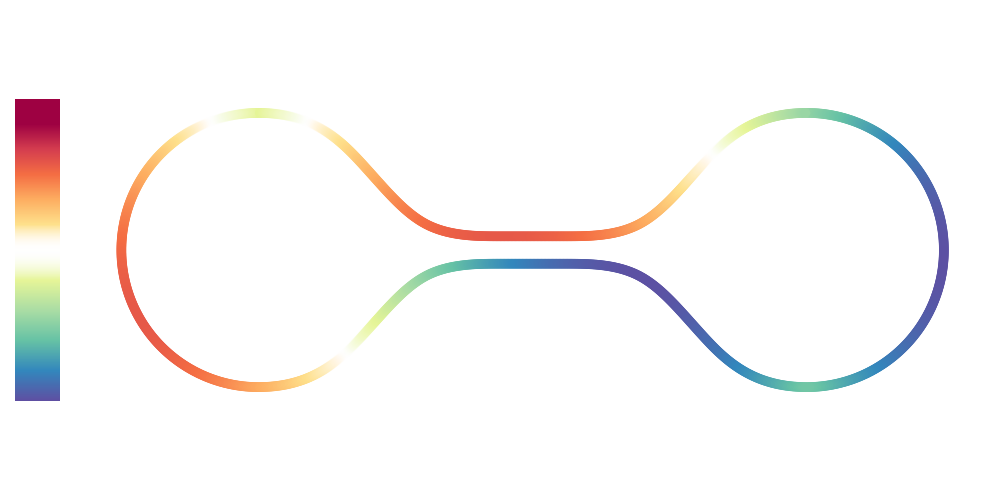

In [31]:
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
im = ax.scatter(noisy_x.cpu().numpy()[:, 0], noisy_x.cpu().numpy()[:, 1], c=sampled_y.numpy(), 
                vmin=vmin, vmax=vmax, cmap=cmap_mean)
# ax.scatter(train_x.cpu().numpy()[:, 0], train_x.cpu().numpy()[:, 1], c=train_y.numpy(), s=300.0, zorder=2, 
#            edgecolors='black', linewidth=2, alpha=1.0, vmin=vmin, vmax=vmax, cmap=cmap_mean)
colorbar(im, fig, ax, ticks=[vmin, 0, vmax])
beautify(fig, ax)

if config["plot"]["save"]:
    fig.savefig("../media/1d_ground_truth.png", format="png", dpi=100, bbox_inches="tight")

### Posterior Mean Manifold

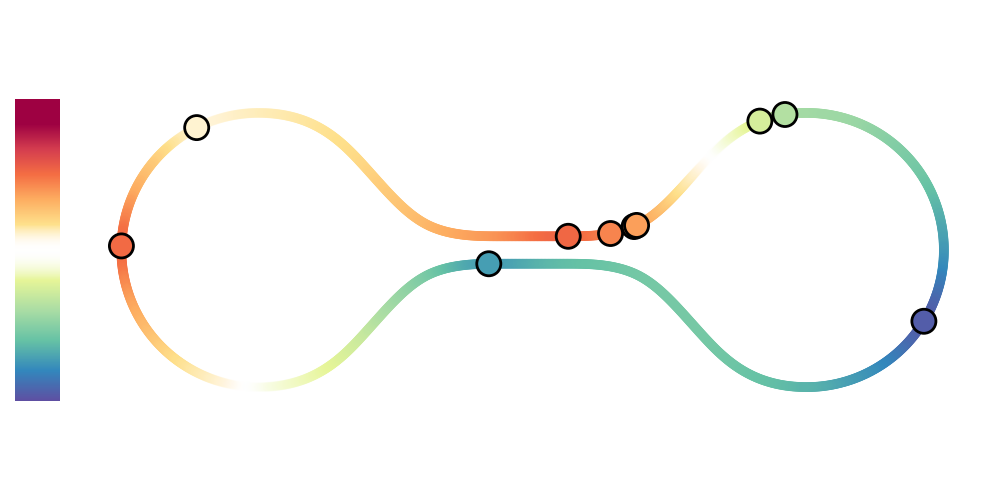

In [32]:
posterior_mean_manifold = preds_manifold.mean.cpu().numpy()
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
step = 21
im = ax.scatter(noisy_x.cpu().numpy()[:, 0], noisy_x.cpu().numpy()[:, 1], c=posterior_mean_manifold, 
                vmin=vmin, vmax=vmax, cmap=cmap_mean)
ax.scatter(train_x.cpu().numpy()[:, 0], train_x.cpu().numpy()[:, 1], c=posterior_mean_manifold[train_idx], s=300.0, zorder=2, 
           edgecolors='black', linewidth=2, alpha=1.0, vmin=vmin, vmax=vmax, cmap=cmap_mean)
# im = ax.scatter(noisy_x.cpu().numpy()[:-2:step, 0], noisy_x.cpu().numpy()[:-2:step, 1], c=posterior_mean_manifold[:-2:step], 
#                 vmin=vmin, vmax=vmax, cmap=cmap_mean,
#                s=100.0, zorder=2, edgecolors='gray', linewidth=2, alpha=1.0)
# ax.scatter(train_x.cpu().numpy()[:, 0], train_x.cpu().numpy()[:, 1], 
#            c=posterior_mean_manifold[train_idx], s=30.0, zorder=2, edgecolors='black', 
#            vmin=vmin, vmax=vmax, cmap=cmap_mean)
# ax.scatter(noisy_x.cpu().numpy()[::step, 0][-1], noisy_x.cpu().numpy()[::step, 1][-1], s=300.0)
colorbar(im, fig, ax, ticks=[vmin, 0, vmax])
beautify(fig, ax)

if config["plot"]["save"]:
    fig.savefig("../media/1d_mean_manifold.png", format="png", dpi= 100, bbox_inches="tight")

### Posterior Mean Ambient Space

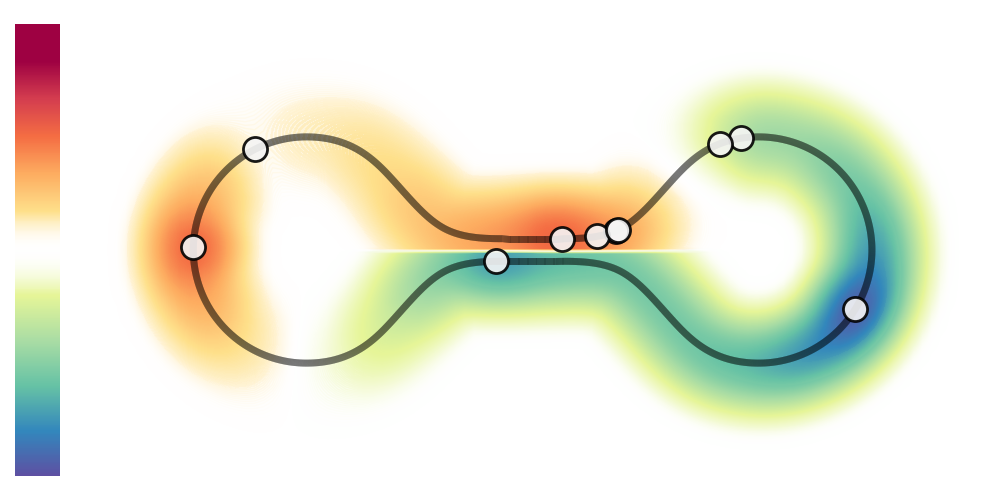

In [33]:
posterior_mean_ambient = model.mean("manifold").cpu().numpy().reshape(resolution, -1)

fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
im = ax.contourf(x.cpu().numpy(), y.cpu().numpy(), posterior_mean_ambient, 
                 levels=np.linspace(vmin, vmax, 500), cmap=cmap_mean)
ax.scatter(train_x.cpu().numpy()[:, 0], train_x.cpu().numpy()[:, 1], facecolors='whitesmoke', s=300.0, zorder=2, 
           edgecolors='black', linewidth=2, alpha=0.9)
for edge in edges:
    start = vertices[edge[0]]
    end = vertices[edge[1]]
    ax.plot([start[0], end[0]], [start[1], end[1]], color='black', zorder=1, linewidth=5, alpha=0.1)
colorbar(im, fig, ax, ticks=[vmin, 0, vmax])
beautify(fig, ax)
for c in im.collections:
    c.set_edgecolor("face")

if config["plot"]["save"]:
    fig.savefig("../media/1d_mean_ambient.png", format="png", dpi=100, bbox_inches="tight")

### Posterior Mean Vanilla

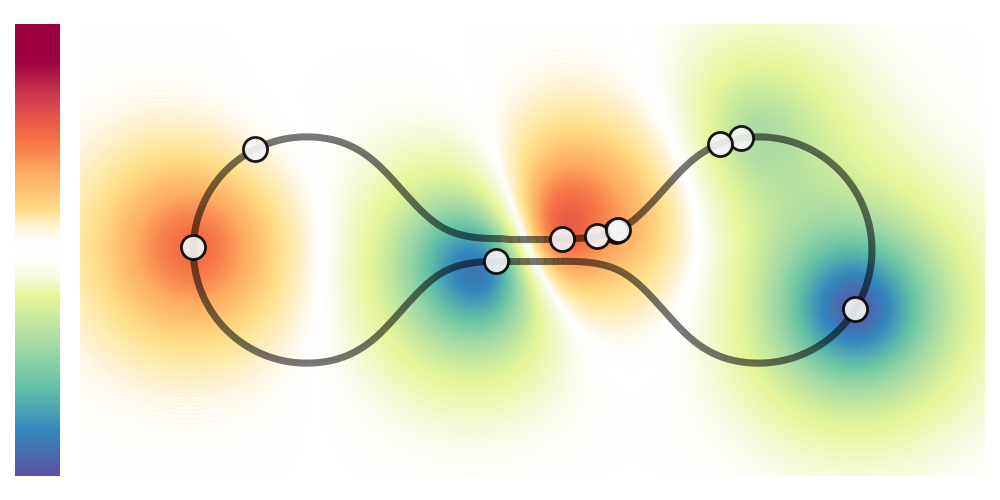

In [34]:
# posterior_mean_vanilla = preds_vanilla.mean.cpu().numpy().reshape(resolution, -1)
posterior_mean_vanilla = model.mean("vanilla").cpu().numpy().reshape(resolution, -1)
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
im = ax.contourf(x.cpu().numpy(), y.cpu().numpy(), posterior_mean_vanilla, 
                 levels=np.linspace(vmin, vmax, 500), cmap=cmap_mean)
ax.scatter(train_x.cpu().numpy()[:, 0], train_x.cpu().numpy()[:, 1], facecolors='whitesmoke', s=300.0, zorder=2, 
           edgecolors='black', linewidth=2, alpha=0.9)
for edge in edges:
    start = vertices[edge[0]]
    end = vertices[edge[1]]
    ax.plot([start[0], end[0]], [start[1], end[1]], color='black', zorder=1, linewidth=5, alpha=0.1)
colorbar(im, fig, ax, ticks=[vmin, 0, vmax])
beautify(fig, ax)
for c in im.collections:
    c.set_edgecolor("face")

if config["plot"]["save"]:
    fig.savefig("../media/1d_mean_vanilla.png", format="png", dpi=100, bbox_inches="tight")

### Posterior Mean Hybrid

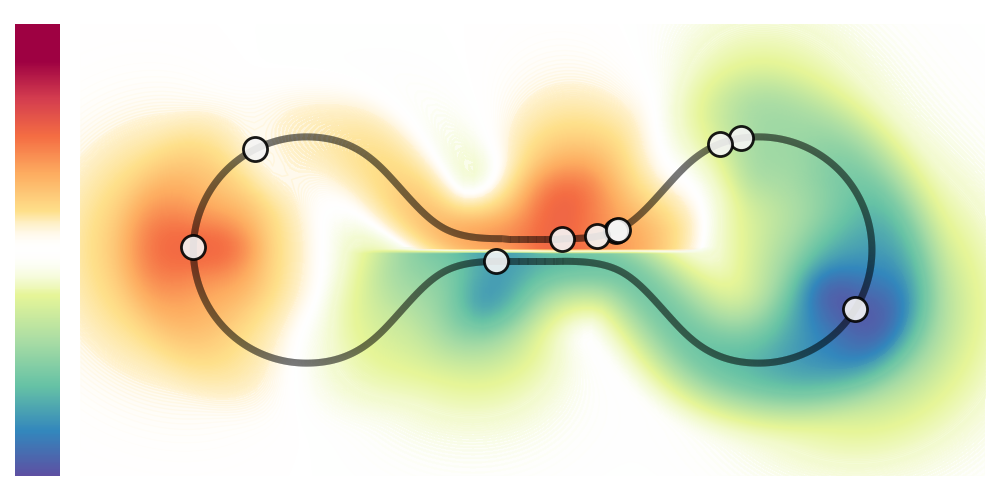

In [35]:
# posterior_mean_hybrid = (scale_ambient*preds_ambient.mean + (1-scale_ambient)*preds_vanilla.mean).cpu().numpy().reshape(resolution, -1)
posterior_mean_hybrid = model.mean("hybrid").cpu().numpy().reshape(resolution, -1)
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
im = ax.contourf(x.cpu().numpy(), y.cpu().numpy(), posterior_mean_hybrid, 
                 levels=np.linspace(vmin, vmax, 500), cmap=cmap_mean)
ax.scatter(train_x.cpu().numpy()[:, 0], train_x.cpu().numpy()[:, 1], facecolors='whitesmoke', s=300.0, zorder=2, 
           edgecolors='black', linewidth=2, alpha=0.9)
for edge in edges:
    start = vertices[edge[0]]
    end = vertices[edge[1]]
    ax.plot([start[0], end[0]], [start[1], end[1]], color='black', zorder=1, linewidth=5, alpha=0.1)
colorbar(im, fig, ax, ticks=[vmin, 0, vmax])
beautify(fig, ax)
for c in im.collections:
    c.set_edgecolor("face")

if config["plot"]["save"]:
    fig.savefig("../media/1d_mean_hybrid.png", format="png", dpi=100, bbox_inches="tight")

### Posterior Standard Deviation Manifold

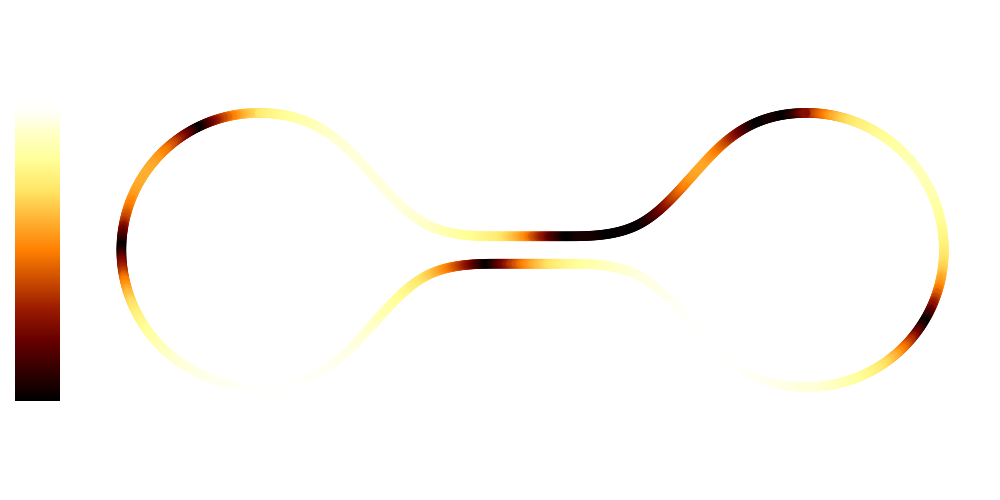

In [36]:
posterior_std_manifold = preds_manifold.stddev.cpu().numpy()
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
im = ax.scatter(noisy_x.cpu().numpy()[:, 0], noisy_x.cpu().numpy()[:, 1], c=posterior_std_manifold, cmap=cmap_std)
colorbar(im, fig, ax)
beautify(fig, ax)

if config["plot"]["save"]:
    fig.savefig("../media/1d_std_manifold.png", format="png", dpi=100, bbox_inches="tight")

### Posterior Standard Deviation Ambient

/home/bernardo/.local/lib/python3.10/site-packages/gpytorch/distributions/multivariate_normal.py:319: NumericalWarning: Negative variance values detected. This is likely due to numerical instabilities. Rounding negative variances up to 1e-06.
  warnings.warn(


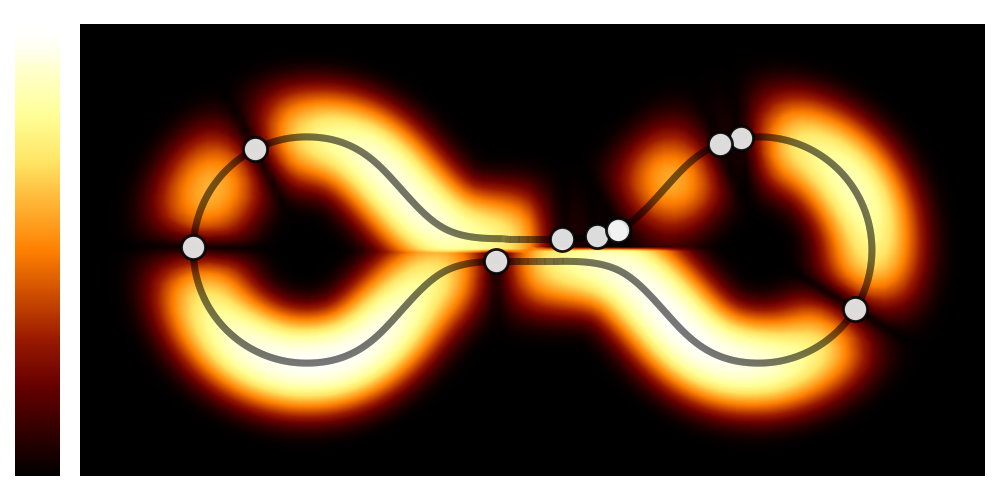

In [37]:
# posterior_std_ambient = preds_ambient.stddev.cpu().numpy().reshape(resolution, -1)
posterior_std_ambient = model.stddev("manifold").cpu().numpy().reshape(resolution, -1)
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
im = ax.contourf(x.cpu(), y.cpu(), posterior_std_ambient, 500, cmap=cmap_std)
ax.scatter(train_x.cpu().numpy()[:, 0], train_x.cpu().numpy()[:, 1], facecolors='whitesmoke', s=300.0, zorder=2, 
       edgecolors='black', linewidth=2, alpha=0.9)
for edge in edges:
    start = vertices[edge[0]]
    end = vertices[edge[1]]
    ax.plot([start[0], end[0]], [start[1], end[1]], color='black', zorder=1, linewidth=5, alpha=0.1)
colorbar(im, fig, ax)
beautify(fig, ax)
for c in im.collections:
    c.set_edgecolor("face")

if config["plot"]["save"]:
    fig.savefig("../media/1d_std_ambient.png", format="png", dpi=100, bbox_inches="tight")

### Posterior Standard Deviation Vanilla

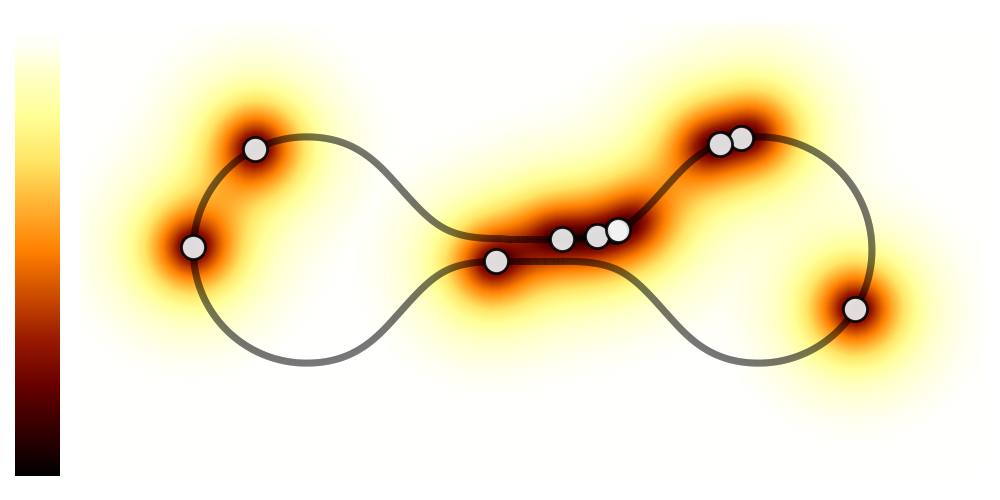

In [38]:
# posterior_std_vanilla = preds_vanilla.stddev.cpu().numpy().reshape(resolution, -1)
posterior_std_vanilla = model.stddev("vanilla").cpu().numpy().reshape(resolution, -1)
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
im = ax.contourf(x.cpu(), y.cpu(), posterior_std_vanilla, 500, cmap=cmap_std)
ax.scatter(train_x.cpu().numpy()[:, 0], train_x.cpu().numpy()[:, 1], facecolors='whitesmoke', s=300.0, zorder=2, 
       edgecolors='black', linewidth=2, alpha=0.9)
for edge in edges:
    start = vertices[edge[0]]
    end = vertices[edge[1]]
    ax.plot([start[0], end[0]], [start[1], end[1]], color='black', zorder=1, linewidth=5, alpha=0.1)
colorbar(im, fig, ax)
beautify(fig, ax)
for c in im.collections:
    c.set_edgecolor("face")

if config["plot"]["save"]:
    fig.savefig("../media/1d_std_vanilla.png", format="png", dpi=100, bbox_inches="tight")

### Posterior Standard Deviation Hybrid

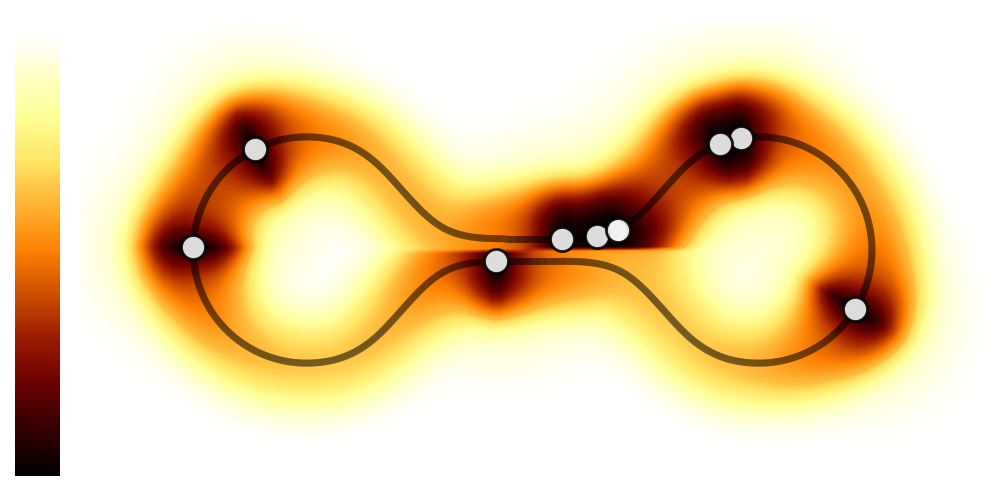

In [39]:
# posterior_std_hybrid = (scale_ambient*preds_ambient.stddev + (1-scale_ambient)*preds_vanilla.stddev).cpu().numpy().reshape(resolution, -1)
posterior_std_hybrid = model.stddev("hybrid").cpu().numpy().reshape(resolution, -1)
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot(111)
im = ax.contourf(x.cpu(), y.cpu(), posterior_std_hybrid, 500, cmap=cmap_std)
ax.scatter(train_x.cpu().numpy()[:, 0], train_x.cpu().numpy()[:, 1], facecolors='whitesmoke', s=300.0, zorder=2, 
       edgecolors='black', linewidth=2, alpha=0.9)
for edge in edges:
    start = vertices[edge[0]]
    end = vertices[edge[1]]
    ax.plot([start[0], end[0]], [start[1], end[1]], color='black', zorder=1, linewidth=5, alpha=0.1)
colorbar(im, fig, ax)
beautify(fig, ax)
for c in im.collections:
    c.set_edgecolor("face")

if config["plot"]["save"]:
    fig.savefig("../media/1d_std_hybrid.png", format="png", dpi=100, bbox_inches="tight")